# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

Set a batch size of 64.

In [2]:
bs = 64

Untar the data at `URLs.PETS`, and set the variable `path` to the returned path with `images` appended to the end.

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

Create a variable `tfms` that captures the output of the `get_transforms` function, with the following arguments:
- max_rotate=20
- max_zoom=1.3
- max_lighting=0.4
- max_warp=0.4
- p_affine=1.
- p_lighting=1.

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

Explain what each of these are.

In [5]:
doc(get_transforms)

Create an `ImageList` from the folder `path` split by a random 20% (using a random seed of 2). Assign it to the variable `src`. What kind of object does this return? Can you find (in code) why this is the case?

In [7]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

Write a function `get_data` that takes `src` and labels it using the regex `([^/]+)_\d+.jpg$`, transforms it with `tfms`, takes `size` as an argument, takes `padding_mode` as an argument that defaults to `reflection`, creates a databunch with batch size `bs`, and normalizes using the imagenet stats. What type would you expect this to return?

In [9]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

Create a variable `data` that calls `get_data` with size 224, `bs=bs`, and padding type `zeros`.

In [10]:
data = get_data(224, bs, 'zeros')

Write a function `_plot` that plots the fourth image in the training dataset. Pass it to `plot_multi` to create a 3x3 grid of augmented images.

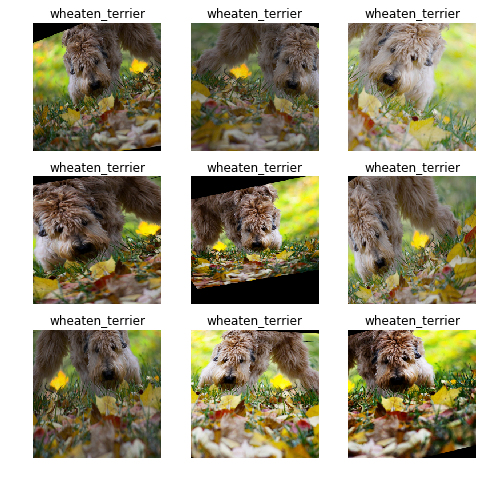

In [11]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

Create a new variable `data` with size 224 and the same bs.

data = get_data(224,bs)

Use the same process to plot a 3x3 grid of 8x8 images of augmented data. This time allow the default padding mode.

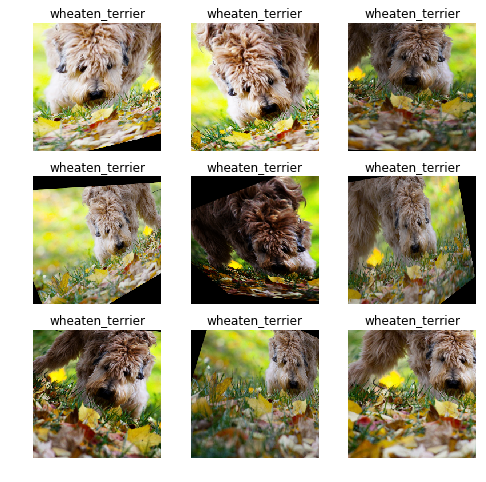

In [12]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

Call `gc.collect`. Can you explain what this does?

Create a `cnn_learner` named `learn` with data `data`, architecture resnet34, using the `error_rate` metric, and `bn_final` set to true.

In [13]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Fit a cycle with 3 epochs, a slice up to 1e-2, with `pct_start=0.8`. Can you explain what `pct_start` does?

In [15]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.390544,1.106928,0.223951,00:48
1,1.408358,0.335443,0.072395,00:45
2,0.887205,0.263976,0.073748,00:46


Unfreeze the neural net. Fit another cycle with two epochs under the slice (1e-6, 1e-3). Same pct_start.

In [16]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.667778,0.274917,0.058863,01:03
1,0.649868,0.266314,0.062246,01:03


Create a new `data` object with size 352.

In [17]:
data = get_data(352,bs)
learn.data = data

Train for another cycle with 2 epochs, this time with a `max_lr` of `slice(1e-6, 1e-4)`.

In [18]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.609314,0.252387,0.050744,02:26
1,0.587843,0.246001,0.049391,02:21


Save the model under the name `352`.

In [19]:
learn.save('352')

## Convolution kernel

Create another new `data` with size 352 and batch size 16.

In [20]:
data = get_data(352,16)

Create a new learner `learn` with the same specs as earlier, and load the weights from `352` to it. 

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Set the variable `idx=0`. Set the values returned at position `idx` within the valid_ds and to `x` and `y`.

Call the `show` method on x.

Return the item at position `idx` in the `y` part of the `valid_ds`.

Category boxer

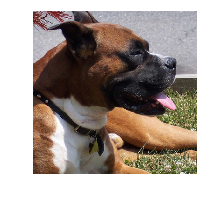

In [22]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

This is created for you, because it doesn't teach much. Maybe dig into the `expand` method.

In [23]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [25]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

Return the shape of `k`.

In [26]:
k.shape

torch.Size([1, 3, 3, 3])

Get the `x` value of the first item in `valid_ds`, get the `data` property and set it to `t`. What does the data property represent? 

In [27]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

Add a new dimension to `t` using the `None` index syntax.

In [29]:
t[None].shape

torch.Size([1, 3, 352, 352])

Create an image called `edge` by convolving `t` with our filter `k`.

In [33]:
edge = F.conv2d(t[None], k)

Run `show_image` over `edge`. Hint: you'll have to get the zeroth index of `edge` -- why?

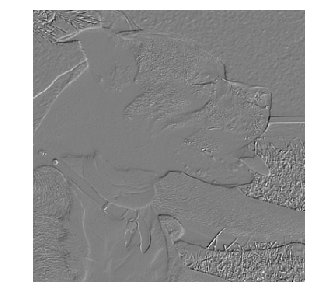

In [34]:
show_image(edge[0], figsize=(5,5));

Show the number of classes in `data`.

In [35]:
data.c

37

Print the model.

In [36]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Print a model summary.

In [37]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________

## Heatmap

Get the model out of our learner and set it to `eval` mode.

In [39]:
m = learn.model.eval();

Get one item from the `x` data you created above. Call this `xb`. Hint: `one_item` returns a tuple, but we only need the first thing.

Create an image from a denormed version of xb. Again, you'll have to index into this. Be sure you can explain why. Call the output `xb_im`.

Put the `xb` variable on the GPU by calling `cuda()`.

In [38]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

Import fastai.callbacks.hooks.

In [43]:
from fastai.callbacks.hooks import *

Create a function `hooked_backward` that returns two objects `grad_a` and `grad_g` representing the activations and the gradients. Make sure to use `with` statements here so that the hooks are removed after we get our results.

In [44]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

Create two objects, `hook_a` and `hook_g` with the outputs of `hooked_backward`.

In [45]:
hook_a,hook_g = hooked_backward()

Assign the stored activation outputs to a variable called `acts`. Make sure to call `.cpu` to put this back on the CPU.

In [46]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

Take an average over the channel dimension to get a 2d shape. Print out the shape.

In [47]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

Write a function `show_heatmap` that does the following:
- takes an argument hm
- Creates a new matplotlib axis using `plt.subplots`
- shows `xb_im` on the new axis
- calls `ax.imshow` with arguments `alpha=0.6`, `extent=(0,352,352,0)`, `interpolation=bilinear`, `cmap=magma`. Look up what these mean.

In [48]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

Call `show_heatmap` on `avg_acts`.

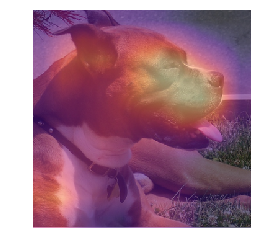

In [49]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

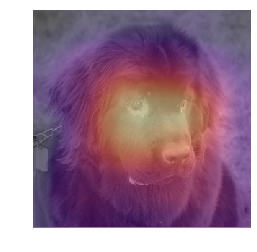

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

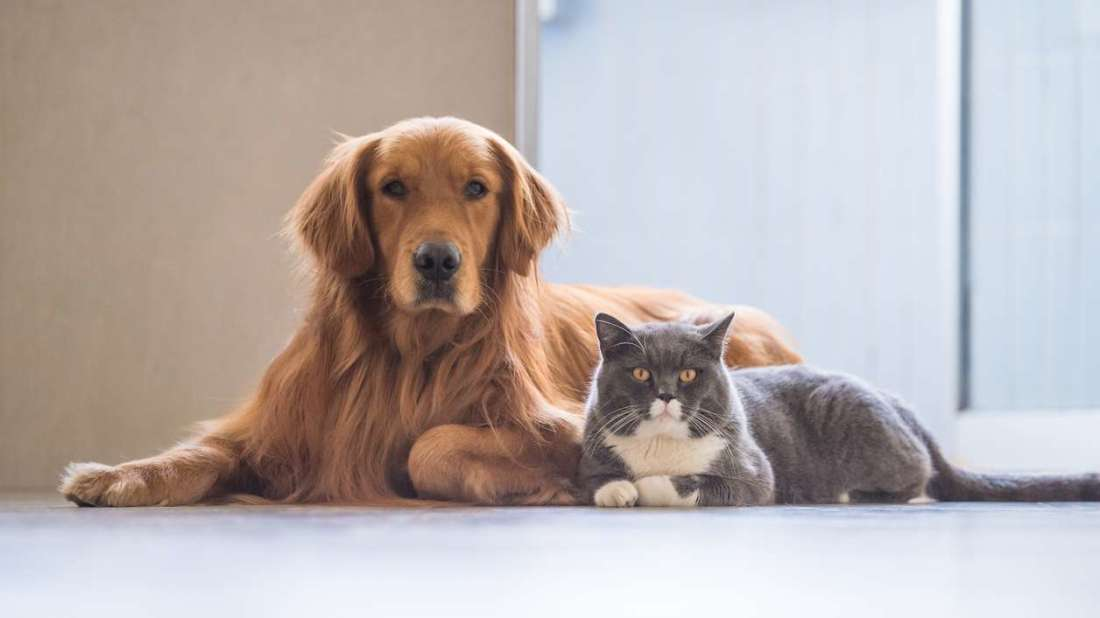

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

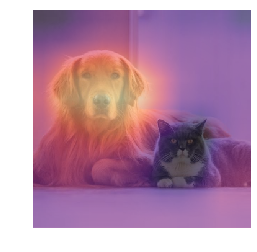

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'Abyssinian'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

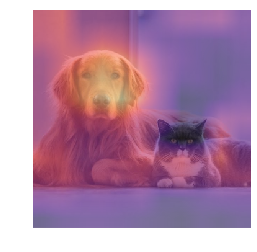

In [ ]:
show_heatmap(mult)

## fin